In [3]:
# Incarcarea librariilor folosite
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model
from keras import optimizers 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Flatten
from keras import initializers
from keras.layers.merge import Concatenate
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

import cv2

In [4]:
# Definirea funcitiei LOSS
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [ ]:
# Definirea metodelor de preprocesare

In [3]:
# Definirea modelului U-net

def Unet(img_size, n_filters, name='Unet',loss = dice_loss):
        
    # parametri specifici
    k=3 # kernel
    s=2 # stride
    img_ch=3 # input channels
    out_ch=1 # output channel
    img_height, img_width = img_size, img_size
    padding='same'
    
    inputs = Input((img_height, img_width, img_ch))
    
    
    green_channel = Lambda(lambda x: x[:,:,:,:1], name="green_channel")(inputs)
    
    conv1 = Conv2D(n_filters, (k, k), padding=padding)(green_channel)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    conv1 = Conv2D(n_filters, (k, k),  padding=padding)(conv1)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    pool1 = MaxPooling2D(pool_size=(s, s))(conv1)
    
    conv2 = Conv2D(2*n_filters, (k, k),  padding=padding)(pool1)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = Activation('relu')(conv2)    
    conv2 = Conv2D(2*n_filters, (k, k),  padding=padding)(conv2)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = Activation('relu')(conv2)    
    pool2 = MaxPooling2D(pool_size=(s, s))(conv2)
     
    conv3 = Conv2D(4*n_filters, (k, k),  padding=padding)(pool2)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = Activation('relu')(conv3)    
    conv3 = Conv2D(4*n_filters, (k, k),  padding=padding)(conv3)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = Activation('relu')(conv3)    
    pool3 = MaxPooling2D(pool_size=(s, s))(conv3)
    
    conv4 = Conv2D(8*n_filters, (k, k),  padding=padding)(pool3)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = Activation('relu')(conv4)    
    conv4 = Conv2D(8*n_filters, (k, k),  padding=padding)(conv4)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = Activation('relu')(conv4)    
    pool4 = MaxPooling2D(pool_size=(s, s))(conv4)
    
    conv5 = Conv2D(16*n_filters, (k, k),  padding=padding)(pool4)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = Activation('relu')(conv5)    
    conv5 = Conv2D(16*n_filters, (k, k),  padding=padding)(conv5)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = Activation('relu')(conv5)
    
    up1 = Concatenate(axis=3)([UpSampling2D(size=(s, s))(conv5), conv4])
    conv6 = Conv2D(8*n_filters, (k, k),  padding=padding)(up1)
    conv6 = BatchNormalization(scale=False, axis=3)(conv6)
    conv6 = Activation('relu')(conv6)    
    conv6 = Conv2D(8*n_filters, (k, k),  padding=padding)(conv6)
    conv6 = BatchNormalization(scale=False, axis=3)(conv6)
    conv6 = Activation('relu')(conv6)    
     
    up2 = Concatenate(axis=3)([UpSampling2D(size=(s, s))(conv6), conv3])
    conv7 = Conv2D(4*n_filters, (k, k),  padding=padding)(up2)
    conv7 = BatchNormalization(scale=False, axis=3)(conv7)
    conv7 = Activation('relu')(conv7)    
    conv7 = Conv2D(4*n_filters, (k, k),  padding=padding)(conv7)
    conv7 = BatchNormalization(scale=False, axis=3)(conv7)
    conv7 = Activation('relu')(conv7)    
    
    up3 = Concatenate(axis=3)([UpSampling2D(size=(s, s))(conv7), conv2])
    conv8 = Conv2D(2*n_filters, (k, k),  padding=padding)(up3)
    conv8 = BatchNormalization(scale=False, axis=3)(conv8)
    conv8 = Activation('relu')(conv8)    
    conv8 = Conv2D(2*n_filters, (k, k),  padding=padding)(conv8)
    conv8 = BatchNormalization(scale=False, axis=3)(conv8)
    conv8 = Activation('relu')(conv8)
    
    up4 = Concatenate(axis=3)([UpSampling2D(size=(s, s))(conv8), conv1])
    conv9 = Conv2D(n_filters, (k, k),  padding=padding)(up4)
    conv9 = BatchNormalization(scale=False, axis=3)(conv9)
    conv9 = Activation('relu')(conv9)    
    conv9 = Conv2D(n_filters, (k, k),  padding=padding)(conv9)
    conv9 = BatchNormalization(scale=False, axis=3)(conv9)
    conv9 = Activation('relu')(conv9)
    
    outputs = Conv2D(out_ch, (1, 1), padding=padding, activation='sigmoid')(conv9)
    
    model = Model(inputs, outputs, name=name)
    model.compile(optimizer='adam', loss=loss, metrics=[dice_coeff])
    return model

In [4]:
# Vizualizarea structurii modelului 

model = Unet(512, 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
green_channel (Lambda)          (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         green_channel[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 192         conv2d[0][0]                     
_______________________________________________________________________________________________

In [5]:
data_gen_args = dict(rescale=1./255,
                     rotation_range=180,
                     zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 8
image_generator =image_datagen.flow_from_directory("dataset/training/images",
                                                    class_mode=None,batch_size=2,target_size=(512, 512), seed=seed)

mask_generator = mask_datagen.flow_from_directory("dataset/training/masks",
                                                   class_mode=None,batch_size=2,target_size=(512, 512), seed=seed)

train_generator = zip(image_generator, mask_generator)

# Validation generator

validation_datagen_img = ImageDataGenerator(rescale=1./255)
validation_datagen_mask = ImageDataGenerator(rescale=1./255)

image_generator_validation =validation_datagen_img.flow_from_directory("dataset/test/images",
                                                    class_mode=None,shuffle=False,batch_size=2,target_size=(512, 512), seed=seed)

mask_generator_validation = validation_datagen_mask.flow_from_directory("dataset/test/masks",
                                                   class_mode=None,shuffle=False,batch_size=2,target_size=(512, 512), seed=seed)
validation_generator = zip(image_generator_validation, mask_generator_validation)

Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Found 9 images belonging to 1 classes.
Found 9 images belonging to 1 classes.


In [ ]:
earlystopper = EarlyStopping(
            patience=10,
            verbose=1)

model_checkpoint = ModelCheckpoint(
            "drive/My Drive/Colab Notebooks/vesselseg",
            monitor='loss',
            verbose=1,
            save_best_only=True)

model.fit(
    train_generator,
    steps_per_epoch=50,
    verbose=1,
    callbacks=[model_checkpoint, earlystopper],
    validation_data=validation_generator,
    validation_steps=4,
    epochs=100)

Epoch 1/50


In [ ]:
model.save("my_h5_model.h5")

In [ ]:
# Testing
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen("dataset/test/images",
                              class_mode=None,
                              # don't shuffle
                              shuffle=False,
                              # use same size as in training
                              target_size=(512, 512))

preds = model.predict_generator(test_generator)

In [5]:
from keras.models import load_model
model = load_model('my_h5_modelv2.h5',custom_objects={'bce_dice_loss': bce_dice_loss})
#model.summary() 

In [26]:
im = cv2.imread("dataset/test/images/images/im0163.ppm")
img= cv2.resize(im, (700,600))

print(img.shape)

(600, 700, 3)


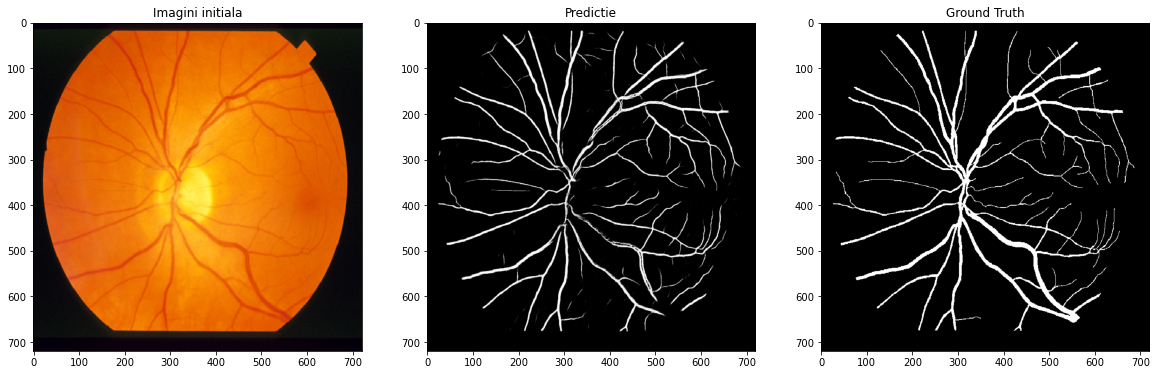

In [6]:
# Generate predictions for all images in the validation set

# Predict on image

image = tf.keras.preprocessing.image.load_img("dataset/test/images/images/im0163.ppm",target_size=(720,720))
input_arr = keras.preprocessing.image.img_to_array(image)/255
input_arr = input_arr.reshape(-1,720,720, 3)
predictions = model.predict(input_arr)
predictions= predictions.reshape(720,720,1)*255

# load border image

border = tf.keras.preprocessing.image.load_img("dataset/test/border/border/im0163.ppm",target_size=(720,720))

# Load the real mask
mask = tf.keras.preprocessing.image.load_img("dataset/test/masks/masks/im0163.ah.ppm",target_size=(720,720))
#plt.show(image)

f, axarr = plt.subplots(1,3,figsize=(20, 10))
axarr[0].set_title('Imagini initiala')
axarr[1].set_title('Predictie')
axarr[2].set_title('Ground Truth')
axarr[0].imshow(image)
axarr[1].imshow(predictions,cmap="gray")
axarr[2].imshow(mask)

In [ ]:
acc = np.sum(predictii==test_labels)/len(predictii)